In [ ]:
import pandas as pd
import numpy as np

# [Step 1] 원본 데이터 로드 및 복사
#customer = pd.read_csv("customer_hm.csv")
#transactions = pd.read_csv("transactions_hm.csv")
#articles = pd.read_csv("articles_hm.csv")

# 경로에 맞게 위 아래 중 선택 주석처리
customer = pd.read_csv('../../data/customer_hm.csv')
transactions = pd.read_csv('../../data/transactions_hm.csv')
articles = pd.read_csv('../../data/articles_hm.csv')

#copy
df_cust = customer.copy()
df_tran = transactions.copy()
df_art = articles.copy()

# [Customer] 데이터 전처리

#1. 'fashion_news_frequency'의 결측치 제거
df_cust['fashion_news_frequency'] = df_cust['fashion_news_frequency'].dropna()

#2. 문자형 정수형으로 매핑 (사전 정의)
status_map = {'ACTIVE': 2, 'PRE-CREATE': 1, 'LEFT CLUB': 0}
frequency_map = {'Regularly': 2, 'Monthly': 1, 'NONE': 0}

#2-2.  매핑 적용
df_cust['club_member_status'] = df_cust['club_member_status'].map(status_map)
df_cust['fashion_news_frequency'] = df_cust['fashion_news_frequency'].map(frequency_map)


#3. 연령대 그룹화 (age_segment) : 나이를 나이대별로 나눠 파생변수 생성
def cate_age(age):
    if age < 20: return '10대'
    elif age < 30: return '20대'
    elif age < 40: return '30대'
    elif age < 50: return '40대'
    elif age < 60: return'50대'
    else: return '60대 이상'

df_cust['age_segment'] = df_cust['age'].apply(cate_age)


# [Transactions] 데이터 전처리

#1. join을 위해 동일한 타입으로 변환
df_tran['customer_id']= df_tran['customer_id'].astype(str)
df_cust['customer_id']= df_cust['customer_id'].astype(str)

df_tran['article_id']= df_tran['article_id'].astype(str).str.zfill(10)
df_art['article_id'] = df_art['article_id'].astype(str).str.zfill(10)

#2. 데이터 크기 및 중복 제거
df_tran.drop_duplicates(inplace=True)

#3. 날짜 타입 변환 및 월 컬럼 생성
df_tran['t_dat'] = pd.to_datetime(df_tran['t_dat'], format='%Y-%m-%d')
df_tran['year_month'] = df_tran['t_dat'].dt.to_period('M')

#4. 판매 채널 한글 컬럼 생성 및 값 변환
df_tran["channel"] = df_tran["sales_channel_id"].map({1: "오프라인", 2: "온라인"})

df_tran["channel"].value_counts() 
numbs = df_tran["channel"].value_counts()
print("온라인:", f"{numbs['온라인']:,}")
print("오프라인:", f"{numbs['오프라인']:,}")
print("전체 거래 건수:", f"{df_tran.shape[0]:,}")

#가격 데이터 분포 확인
df_tran['price'].describe() 
print("price가 0.1 이상:", len(df_tran[df_tran["price"] >= 0.1]))
print("price가 0.2 이상:", len(df_tran[df_tran["price"] >= 0.2]))
print("price가 0.3 이상:", len(df_tran[df_tran["price"] >= 0.3]))
print("price가 0.4 이상:", len(df_tran[df_tran["price"] >= 0.4]))
print("price가 0.5 이상:", len(df_tran[df_tran["price"] >= 0.5]))

#고가 거래 분리 및 채널 확인
high_price_transactions = df_tran[df_tran["price"] >= 0.4]
high_price_transactions['sales_channel_id'].replace({1: 'Offline', 2: 'Online'}).value_counts() 

#월별 거래 건수 & 매출액 계산
monthly_sales = df_tran.groupby('year_month').size()
monthly_price = df_tran.groupby('year_month')['price'].sum()

print(monthly_price)

#최고 매출 월 
best_month = monthly_price.idxmax()
best_value = monthly_price.max()

print("가장 매출이 높은 달:", best_month)
print("그 달의 매출:", best_value) 


# [Article] 데이터 전처리: 상품 전략 파생변수 생성

#1. ID 형식 통일
df_art['article_id'] = df_art['article_id'].astype(str).str.zfill(10)

#2. 결측치(NULL) 제어 (detail_desc의 NULL값을 No Description로)
df_art['detail_desc'] = df_art['detail_desc'].fillna('No Description')

#3. 불필요 컬럼 제거 (메모리 줄이기) : Name(이름)이 존재하여 중복 정보인 Code(코드성 숫자) 컬럼 불필요
cols_to_drop = [
    'product_type_no', 
    'graphical_appearance_no', 
    'colour_group_code', 
    'perceived_colour_value_id',
    'perceived_colour_master_id',
    'department_no',
    'index_code',
    'index_group_no',
    'section_no',
    'garment_group_no'
]
df_art_cleaned = df_art.drop(columns=cols_to_drop) 

#4. 매핑 및 파생변수 설정
#4-1. 시즌 별 매핑 (product_season) / 시즌성 구분을 위한 키워드 정의
def get_season(section):
    section = section.lower()
    # FW
    if any(kw in section for kw in ['outerwear', 'nightwear', 'socks', 'tights', 'knitted']):
        return 'FW'
    # SS
    elif any(kw in section for kw in ['swimwear', 'sport', 'shorts', 'sandals']):
        return 'SS'
    # 두루두루 아이템(all season)
    else:
        return 'All-Season'

#4-2. 파생변수 생성 및 이름만 조금 더 직관적으로 분류
df_art_cleaned['product_season'] = df_art_cleaned['section_name'].apply(get_season)
#4-3. 메인 카테고리 정의 (원본 보존)
df_art_cleaned['category_main'] = df_art_cleaned['index_group_name']   


#5. 저관여/고관여 제품 분류 (product_strategy)
def get_involvement_strategy(row):
    garment = str(row['garment_group_name']).lower()
    section = str(row['section_name']).lower()
    # 1. 저관여 (베이직)
    if any(kw in garment for kw in ['basic', 'underwear', 'socks', 'jersey']) or \
       'basic' in section:
        return 'Low_Involvement_Basic'
    # 2. 고관여 (전략템/트렌드템)
    elif any(kw in garment for kw in ['knitwear', 'outerwear', 'dresses']) or \
         any(kw in section for kw in ['trend', 'special']):
        return 'High_Involvement_Strategic'
    else:
        return 'General_Fashion'
    
df_art_cleaned['product_strategy'] = df_art_cleaned.apply(get_involvement_strategy, axis=1)

#6. 신상품/트렌드 키워드 추출 (is_new)
def check_newness(row):
    text = (str(row['prod_name']) + " " + str(row['detail_desc'])).lower()
    new_keywords = ['new', 'collection', 'latest', 'trend', 'exclusive']
    
    if any(kw in text for kw in new_keywords):
        return 'New_Arrival'
    return 'Regular_Carryover'

df_art_cleaned['is_new'] = df_art_cleaned.apply(check_newness, axis=1)

#7. 색상 그룹화 (color_tone)
def get_color_tone(color):
    color = str(color).lower()
    dark_colors = ['black', 'dark blue', 'dark grey', 'dark red', 'navy blue', 'dark green', 'anthracite']
    light_colors = ['white', 'light beige', 'off white', 'light pink', 'light blue', 'yellowish brown']
    
    if any(dc in color for dc in dark_colors):
        return 'Dark_Tone'
    elif any(lc in color for lc in light_colors):
        return 'Light_Tone'
    else:
        return 'Neutral_Tone'

df_art_cleaned['color_tone'] = df_art_cleaned['colour_group_name'].apply(get_color_tone)

온라인: 721,488
오프라인: 318,613
전체 거래 건수: 1,040,101
price가 0.1 이상: 10704
price가 0.2 이상: 719
price가 0.3 이상: 126
price가 0.4 이상: 29
price가 0.5 이상: 2
year_month
2019-01    2129.926131
2019-02    1989.217641
2019-03    2374.905504
2019-04    2703.443538
2019-05    2748.199469
2019-06    3088.776976
2019-07    2552.035334
2019-08    1943.422489
2019-09    2559.226862
2019-10    2358.486793
2019-11    2463.769270
2019-12    1985.492149
Freq: M, Name: price, dtype: float64
가장 매출이 높은 달: 2019-06
그 달의 매출: 3088.776976142


df_tran 기준으로 df_cust, df_art_cleaned 조인

In [28]:
#  첫 번째 조인: 거래 + 고객 (customer_id 기준)
merged_df = pd.merge(df_tran, df_cust, on='customer_id', how='left')

# 두 번째 조인: (거래+고객) + 상품 (article_id 기준)
final_df = pd.merge(merged_df, df_art_cleaned, on='article_id', how='left')

# 결과 확인
print(df_tran.shape)
print(final_df.shape)
final_df.head()

(1040101, 7)
(1040101, 32)


,t_dat,customer_id,article_id,price,sales_channel_id,year_month,channel,FN,Active,club_member_status,...,index_name,index_group_name,section_name,garment_group_name,detail_desc,product_season,category_main,product_strategy,is_new,color_tone
0,2019-11-05,3e2b60b679e62fb49516105b975560082922011dd752ec...,0698328010,0.016932,2,2019-11,온라인,1.0,1.0,2.0,...,Divided,Divided,Divided Collection,Jersey Fancy,Top in lightweight sweatshirt fabric with drop...,All-Season,Divided,Low_Involvement_Basic,Regular_Carryover,Dark_Tone
1,2019-05-22,89647ac2274f54c770aaa4b326e0eea09610c252381f37...,0760597002,0.033881,2,2019-05,온라인,0.0,0.0,2.0,...,Ladieswear,Ladieswear,Womens Casual,Jersey Fancy,"Short-sleeved blouse in stretch, textured jers...",All-Season,Ladieswear,Low_Involvement_Basic,Regular_Carryover,Light_Tone
2,2019-05-10,2ebe392150feb60ca89caa8eff6c08b7ef1138cd6fdc71...,0488561032,0.016932,2,2019-05,온라인,1.0,1.0,2.0,...,Menswear,Menswear,Contemporary Casual,Shorts,Knee-length shorts in soft washed cotton with ...,All-Season,Menswear,General_Fashion,Regular_Carryover,Dark_Tone
3,2019-08-26,7b3205de4ca17a339624eb5e3086698e9984eba6b47c56...,0682771001,0.033881,2,2019-08,온라인,0.0,0.0,2.0,...,Ladies Accessories,Ladieswear,Womens Big accessories,Accessories,Shopper in grained imitation leather with two ...,All-Season,Ladieswear,General_Fashion,Regular_Carryover,Dark_Tone
4,2019-08-10,3b77905de8b32045f08cedb79200cdfa477e9562429a39...,0742400033,0.003220,1,2019-08,오프라인,0.0,0.0,2.0,...,Menswear,Menswear,Men Underwear,Socks and Tights,"Socks in a soft, fine-knit cotton blend with r...",All-Season,Menswear,Low_Involvement_Basic,Regular_Carryover,Light_Tone


In [ ]:
# 고객 정보 결측치를 'Unknown'으로 채우기
final_df = final_df.fillna('Unknown')

# 결측치가 잘 채워졌는지 확인
print(final_df['age_segment'].value_counts())
print(final_df['club_member_status'].value_counts())
print(final_df['FN'].value_counts())
print(final_df['Active'].value_counts())
print(final_df['fashion_news_frequency'].value_counts()) 

age_segment
20대        329534
Unknown    233734
30대        164457
50대        135167
40대        125774
60대 이상      37794
10대         13641
Name: count, dtype: int64
club_member_status
2.0        789730
Unknown    233734
1.0         16377
0.0           260
Name: count, dtype: int64
FN
0.0        456900
1.0        349467
Unknown    233734
Name: count, dtype: int64
Active
0.0        461862
1.0        344505
Unknown    233734
Name: count, dtype: int64
fashion_news_frequency
0.0        455837
2.0        350272
Unknown    233734
1.0           258
Name: count, dtype: int64


In [34]:
# 각 상태별로 고객이 몇 명인지 확인
df_cust['club_member_status'].value_counts()

club_member_status
2    982635
1     65581
0       359
Name: count, dtype: int64

In [7]:
final_df['club_member_status'].value_counts()

club_member_status
2.0        789730
Unknown    233734
1.0         16377
0.0           260
Name: count, dtype: int64

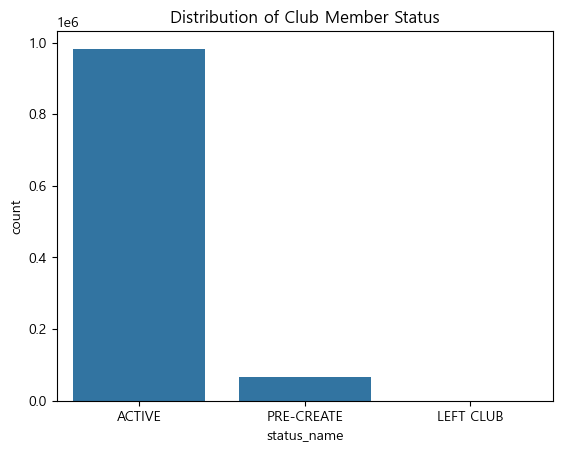

In [46]:
### join 전 club_member_status 시각화

import seaborn as sns
import matplotlib.pyplot as plt

status_map = {
    0: 'LEFT CLUB',
    1: 'PRE-CREATE',
    2: 'ACTIVE'
    }

temp_df = df_cust.copy()
temp_df['status_name'] = temp_df['club_member_status'].map(status_map)


sns.countplot(data=temp_df, 
              x='status_name')
plt.title("Distribution of Club Member Status")

# dpi=300은 고화질, bbox_inches='tight'는 여백 없이 깔끔하게 저장
plt.savefig('Beforejoin Club Member Status.png', dpi=300, bbox_inches='tight')

plt.show()

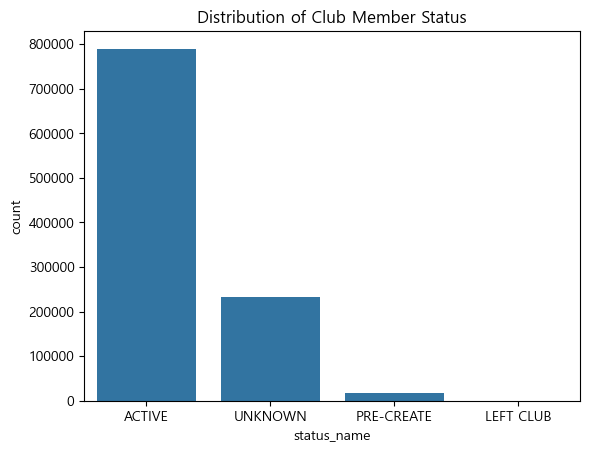

In [47]:
### join 후 club_member_status 시각화

import seaborn as sns
import matplotlib.pyplot as plt

status_map = {
    0: 'LEFT CLUB',
    1: 'PRE-CREATE',
    2: 'ACTIVE',
    'Unknown': 'UNKNOWN'
    }

temp2_df = final_df.copy()
temp2_df['status_name'] = temp2_df['club_member_status'].map(status_map)


sns.countplot(data=temp2_df, 
              x='status_name')
plt.title("Distribution of Club Member Status")

# dpi=300은 고화질, bbox_inches='tight'는 여백 없이 깔끔하게 저장
plt.savefig('Afterjoin Club Member Status.png', dpi=300, bbox_inches='tight')

plt.show()

In [36]:
df_cust["age_segment"].value_counts()

age_segment
20대       409196
30대       181112
50대       174715
40대       157445
60대 이상     70851
10대        55256
Name: count, dtype: int64

In [37]:
# 전체에서 차지하는 비율 확인
final_df["age_segment"].value_counts()

age_segment
20대        329534
Unknown    233734
30대        164457
50대        135167
40대        125774
60대 이상      37794
10대         13641
Name: count, dtype: int64

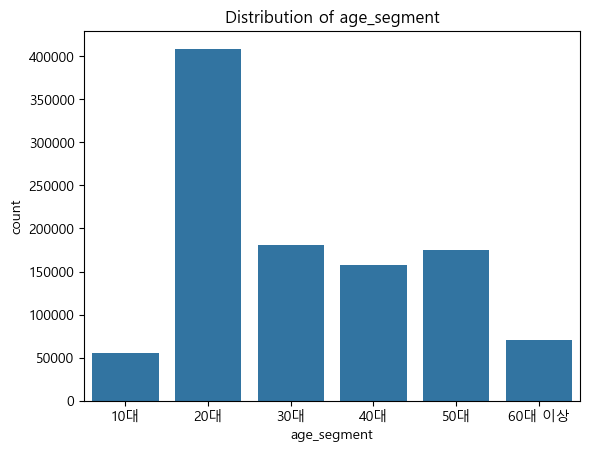

In [48]:
#조인 전 age_segment 시각화
import seaborn as sns
import matplotlib.pyplot as plt
import platform

# 한글 깨짐 방지 설정
if platform.system() == 'Darwin': # 맥(Mac)
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows': # 윈도우(Windows)
    plt.rc('font', family='Malgun Gothic')

sns.countplot(data=df_cust, 
              x='age_segment',
              order=['10대', '20대', '30대', '40대', '50대', '60대 이상'])
plt.title("Distribution of age_segment")

# dpi=300은 고화질, bbox_inches='tight'는 여백 없이 깔끔하게 저장
plt.savefig('Beforejoin age segment.png', dpi=300, bbox_inches='tight')
plt.show()

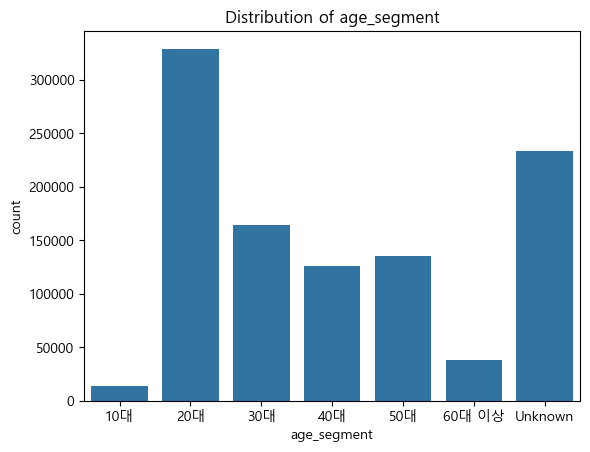

In [49]:
#조인 후 age_segment 시각화
import seaborn as sns
import matplotlib.pyplot as plt
import platform

# 한글 깨짐 방지 설정
if platform.system() == 'Darwin': # 맥(Mac)
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows': # 윈도우(Windows)
    plt.rc('font', family='Malgun Gothic')

sns.countplot(data=final_df, 
              x='age_segment',
              order=['10대', '20대', '30대', '40대', '50대', '60대 이상', 'Unknown'])
plt.title("Distribution of age_segment")

# dpi=300은 고화질, bbox_inches='tight'는 여백 없이 깔끔하게 저장
plt.savefig('Afterjoin age segment.png', dpi=300, bbox_inches='tight')
plt.show()